In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [10]:
# Load data
data = pd.read_csv('../01_Data/data_california_house_prepared.csv')

In [11]:
# Membuat fitur baru
data['rooms_per_household'] = data['total_rooms']/data['households']
data['bedrooms_per_room'] = data['total_bedrooms']/data['total_rooms']
data['population_per_household'] = data['population']/data['households']

In [12]:
# Pisahkan fitur dan target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

RANDOM_STATE = 42

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE)

# Definisikan fitur numerik & kategorikal
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                    'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']
categorical_features = ['ocean_proximity']

# Preprocessor: Imputasi + Scaling + Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [13]:
# Daftar model dengan parameter grid untuk tuning
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            'fit_intercept': [True, False],
            'positive': [True, False]
        }
    },
    "Ridge Regression": {
        "model": Ridge(random_state=RANDOM_STATE),
        "params": {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        }
    },
    "Lasso Regression": {
        "model": Lasso(random_state=RANDOM_STATE),
        "params": {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
            'selection': ['cyclic', 'random']
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=RANDOM_STATE),
        "params": {
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=RANDOM_STATE),
        "params": {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
        "params": {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }
}

In [14]:

def randomized_search_tuning(X_train, y_train, preprocessor, models):
    best_models = {}
    fitted_models = {}  # Menyimpan pipeline yang sudah di-fit
    
    param_distributions = {
        "Linear Regression": {
            'regressor__fit_intercept': [True, False],
            'regressor__positive': [True, False]
        },
        "Ridge Regression": {
            'regressor__alpha': uniform(0.1, 100),
            'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        },
        "Lasso Regression": {
            'regressor__alpha': uniform(0.001, 10),
            'regressor__selection': ['cyclic', 'random']
        },
        "Decision Tree": {
            'regressor__max_depth': randint(1, 50),
            'regressor__min_samples_split': randint(2, 20),
            'regressor__min_samples_leaf': randint(1, 10)
        },
        "Random Forest": {
            'regressor__n_estimators': randint(50, 300),
            'regressor__max_depth': randint(1, 50),
            'regressor__min_samples_split': randint(2, 20),
            'regressor__min_samples_leaf': randint(1, 10)
        },
        "XGBoost": {
            'regressor__n_estimators': randint(50, 300),
            'regressor__max_depth': randint(3, 15),
            'regressor__learning_rate': uniform(0.01, 0.3),
            'regressor__subsample': uniform(0.6, 0.4),
            'regressor__colsample_bytree': uniform(0.6, 0.4)
        }
    }

    
    for name, model_info in models.items():
        print(f"\nRandomizedSearchCV untuk {name}...")
        
        pipeline = Pipeline(steps=[
            ('preprocessing', preprocessor),
            ('regressor', model_info["model"])
        ])
        
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions[name],
            n_iter=10,
            cv=5,
            scoring='neg_mean_squared_error',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=1
        )
        random_search.fit(X_train, y_train)
        
        best_models[name] = {
            "best_model": random_search.best_estimator_,
            "best_params": random_search.best_params_,
            "best_score": np.sqrt(-random_search.best_score_)
        }
        fitted_models[name] = random_search.best_estimator_  # Simpan pipeline yang sudah di-fit
        
        print(f"Best parameters for {name}: {random_search.best_params_}")
        print(f"Best RMSE for {name}: {np.sqrt(-random_search.best_score_):.4f}")
    
    return best_models, fitted_models


RandomizedSearchCV untuk Linear Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


d:\PurwadhikaBackup\capstoneproject\modultiga\california_housing_price_prediction\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Linear Regression: {'regressor__positive': False, 'regressor__fit_intercept': False}
Best RMSE for Linear Regression: 69773.0436

RandomizedSearchCV untuk Ridge Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Ridge Regression: {'regressor__alpha': np.float64(2.1584494295802448), 'regressor__solver': 'svd'}
Best RMSE for Ridge Regression: 69805.2838

RandomizedSearchCV untuk Lasso Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


d:\PurwadhikaBackup\capstoneproject\modultiga\california_housing_price_prediction\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.733e+12, tolerance: 1.537e+10
  model = cd_fast.enet_coordinate_descent(


Best parameters for Lasso Regression: {'regressor__alpha': np.float64(0.008787658410143284), 'regressor__selection': 'random'}
Best RMSE for Lasso Regression: 69773.0701

RandomizedSearchCV untuk Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Decision Tree: {'regressor__max_depth': 11, 'regressor__min_samples_leaf': 8, 'regressor__min_samples_split': 5}
Best RMSE for Decision Tree: 61087.9903

RandomizedSearchCV untuk Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Random Forest: {'regressor__max_depth': 24, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 3, 'regressor__n_estimators': 137}
Best RMSE for Random Forest: 51459.4080

RandomizedSearchCV untuk XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for XGBoost: {'regressor__colsample_bytree': np.float64(0.7599443886861021), 'regressor__learning_rate': np.float64(0.023999698964

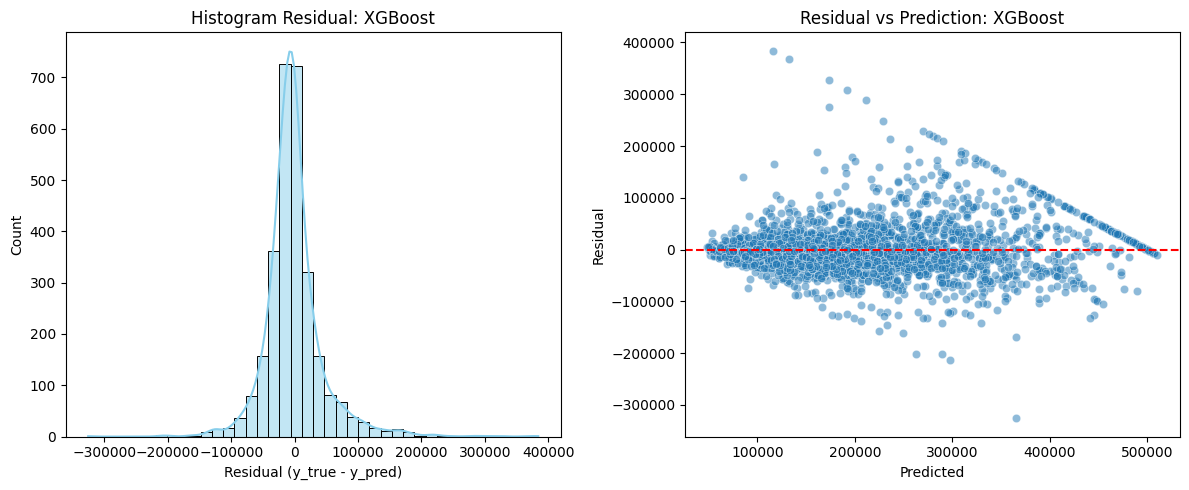

In [ ]:
# Lakukan tuning dan dapatkan model terbaik
best_models, fitted_models = randomized_search_tuning(X_train, y_train, preprocessor, models)

def evaluate(y_true, y_pred):
    residuals = y_true - y_pred
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, mape, r2, residuals

# Evaluasi model pada test set
results = []
residuals_dict = {}

for name, pipeline in fitted_models.items():
    y_pred = pipeline.predict(X_test)
    mae, mse, rmse, mape, r2, residuals = evaluate(y_test, y_pred)
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
    residuals_dict[name] = (y_pred, residuals)

📊 Evaluasi Model:
                Model           MAE           MSE          RMSE      MAPE        R²
5            XGBoost  30121.064996  2.168598e+09  46568.212474  0.170195  0.837571
4      Random Forest  32654.598575  2.540000e+09  50398.408269  0.182628  0.809753
3      Decision Tree  40189.698377  3.661792e+09  60512.742266  0.221761  0.725730
1   Ridge Regression  49118.301697  4.838332e+09  69558.122155  0.288293  0.637606
2   Lasso Regression  49125.973104  4.840790e+09  69575.787854  0.288424  0.637422
0  Linear Regression  49125.982771  4.840793e+09  69575.809039  0.288424  0.637422

✅ Model terbaik berdasarkan RMSE: **XGBoost**


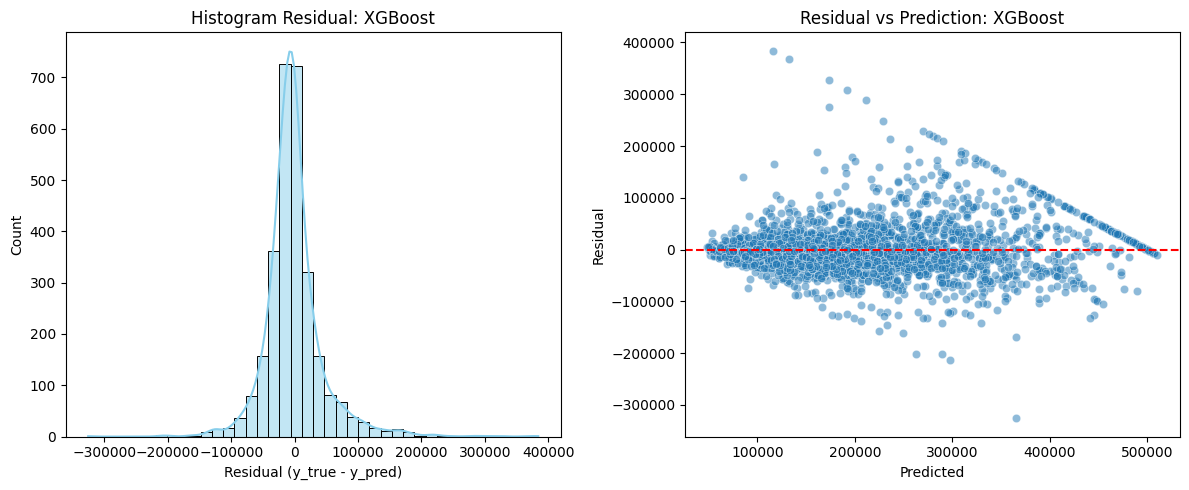

In [19]:
# Atur opsi pandas untuk menampilkan semua kolom
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Mencegah pemotongan horizontal

# Tampilkan hasil evaluasi
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("📊 Evaluasi Model:\n", results_df)

# Kembalikan opsi ke default jika diperlukan
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')

# 💡 Saran model terbaik (berdasarkan RMSE)
best_model_name = results_df.iloc[0]['Model']
print(f"\n✅ Model terbaik berdasarkan RMSE: **{best_model_name}**")

# -----------------------------------
# 🔍 Residual Analysis (Visualisasi)
# -----------------------------------
y_pred_best, residuals_best = residuals_dict[best_model_name]

plt.figure(figsize=(12, 5))

# Histogram residual
plt.subplot(1, 2, 1)
sns.histplot(residuals_best, bins=40, kde=True, color='skyblue')
plt.title(f"Histogram Residual: {best_model_name}")
plt.xlabel("Residual (y_true - y_pred)")

# Scatter y_pred vs residual
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_best, y=residuals_best, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residual vs Prediction: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()

In [16]:
# ------------------------------
# 🔍 Feature importance (jika applicable)
# ------------------------------
best_pipeline = fitted_models[best_model_name]
best_model = best_pipeline.named_steps['regressor']  # Ambil model dari pipeline

# Dapatkan nama fitur akhir setelah preprocessing
preprocessor_fitted = best_pipeline.named_steps['preprocessing']
ohe = preprocessor_fitted.named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)

feature_names = numeric_features + list(encoded_cat_names)

print(f"\n📊 Feature Importance untuk model: {best_model_name}")
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    for idx in sorted_idx:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
elif hasattr(best_model, "coef_"):
    coef = best_model.coef_
    if coef.ndim > 1:
        coef = coef[0]  # Handle shape (1, n)
    sorted_idx = np.argsort(np.abs(coef))[::-1]
    for idx in sorted_idx:
        print(f"{feature_names[idx]}: {coef[idx]:.4f}")
else:
    print("⚠️ Model ini tidak mendukung feature importance secara langsung.")


📊 Feature Importance untuk model: XGBoost
ocean_proximity_INLAND: 0.8104
median_income: 0.0537
ocean_proximity_NEAR BAY: 0.0234
ocean_proximity_NEAR OCEAN: 0.0201
ocean_proximity_<1H OCEAN: 0.0177
population_per_household: 0.0154
rooms_per_household: 0.0123
bedrooms_per_room: 0.0097
latitude: 0.0083
longitude: 0.0060
housing_median_age: 0.0057
population: 0.0051
households: 0.0049
total_bedrooms: 0.0038
total_rooms: 0.0036


In [17]:
# Simpan model terbaik
joblib.dump(best_pipeline, '../03_Model/03B_best_model.pkl')
print('✅ Model berhasil disimpan')

✅ Model berhasil disimpan
